## Dog/Cat classification using pretrained model MobileNet V2

In [1]:
# Import libraries
import os
import pathlib
import glob
import tensorflow as tf
import numpy as np

### Get Image path and label from dataset

In [2]:
# load root folder of images
data_root_orig = './train'
# Get all images name
data_root = os.listdir(data_root_orig)

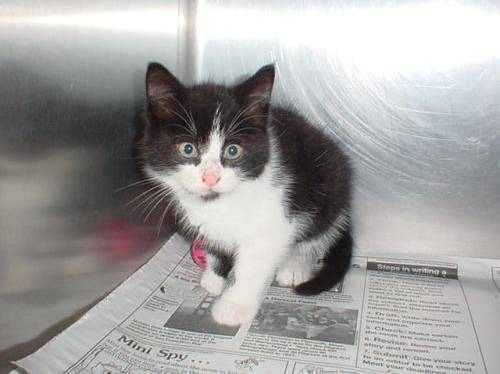

In [5]:
# Plot an example to make sure the path works.
import IPython.display as display
display.display(display.Image('./train/' + str(data_root[0])))

In [6]:
# Shuffle our images name for better model training.
import random
random.shuffle(data_root)

In [9]:
# Take a look of data_root now
data_root[:10]

['cat.9357.jpg',
 'dog.5923.jpg',
 'dog.2683.jpg',
 'cat.701.jpg',
 'dog.5036.jpg',
 'dog.3412.jpg',
 'cat.2643.jpg',
 'cat.5291.jpg',
 'cat.10444.jpg',
 'cat.979.jpg']

In [10]:
# load all images label by using split.
category = []
for p in data_root:
    ca = p.split(".")[0]
    category.append(ca)

In [11]:
# Turn Cat and dog to binary.
bi_category = []
for i in category:
    if i == 'cat':
        a = 0
    else:
        a = 1
    bi_category.append(a)
y = bi_category
y[:10]

In [14]:
X = data_root

In [15]:
X[:10]

['cat.9357.jpg',
 'dog.5923.jpg',
 'dog.2683.jpg',
 'cat.701.jpg',
 'dog.5036.jpg',
 'dog.3412.jpg',
 'cat.2643.jpg',
 'cat.5291.jpg',
 'cat.10444.jpg',
 'cat.979.jpg']

In [28]:
# Create fully path for each images
for i in range(len(X)):
    X[i] = './train/' + X[i]

### Now we have X and y for next step.

## Preprocess data

In [33]:
# define function for preprocess data
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [192, 192])
    image /= 255.0  # normalize to [0,1] range
    image = 2*image-1  # normalize to [-1,1] range

    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


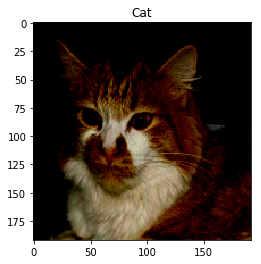

In [35]:
# Plot an example after preprocess.You can see the size is 192x192 now
import matplotlib.pyplot as plt

image_path = X[0]
label = y[0]

plt.imshow(load_and_preprocess_image(image_path))
plt.grid(False)
plt.title(category[label].title())
plt.show()

### Load and format all images by calling function above and map them with label.

In [36]:
# Slicing the array of strings, results in a dataset of strings:
ds = tf.data.Dataset.from_tensor_slices((X, y))

# The tuples are unpacked into the positional arguments of the mapped function
def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label

image_label_ds = ds.map(load_and_preprocess_from_path_label)
image_label_ds

<MapDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int32)>

### To train a model with this dataset, you will want the data:

    To be well shuffeled
    To be batched
    To repeat forever
    Batches to be available as soon as possible

In [38]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE
image_count = len(X)

# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
ds = image_label_ds.shuffle(bu ffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches in the background while the model is training.
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>

## It's time for model.but i still have no ideal what is mobile net

In [39]:
# Fetch a copy of MobileNet v2 from tf.keras.applications
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192, 192, 3), include_top=False)
mobile_net.trainable=False

9412608/9406464 [==============================] - 1s 0us/step


### Build a model wrapped around MobileNet and use tf.keras.layers.GlobalAveragePooling2D to average over those space dimensions before the output tf.keras.layers.Dense layer:

In [40]:
model = tf.keras.Sequential([
    mobile_net,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(2, activation = 'sigmoid')])

In [41]:
# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


### Can't wait for train it.Thank to GG.Your GPU Tesla K80 is extremely fast

In [43]:
steps_per_epoch=tf.math.ceil(len(X)/BATCH_SIZE).numpy()
history = model.fit(ds, epochs=10, steps_per_epoch=steps_per_epoch)

Train for 782.0 steps
Epoch 1/10
782/782 [==============================] - 310s 397ms/step - loss: 0.1443 - accuracy: 0.9412
Epoch 2/10
782/782 [==============================] - 97s 124ms/step - loss: 0.1121 - accuracy: 0.9564
Epoch 3/10
782/782 [==============================] - 97s 124ms/step - loss: 0.1000 - accuracy: 0.9610
Epoch 4/10
782/782 [==============================] - 96s 123ms/step - loss: 0.1000 - accuracy: 0.9611
Epoch 5/10
782/782 [==============================] - 96s 122ms/step - loss: 0.0991 - accuracy: 0.9605
Epoch 6/10
782/782 [==============================] - 95s 121ms/step - loss: 0.0917 - accuracy: 0.9629
Epoch 7/10
782/782 [==============================] - 92s 118ms/step - loss: 0.0875 - accuracy: 0.9649
Epoch 8/10
782/782 [==============================] - 89s 114ms/step - loss: 0.0918 - accuracy: 0.9631
Epoch 9/10
782/782 [==============================] - 81s 103ms/step - loss: 0.0859 - accuracy: 0.9652
Epoch 10/10
782/782 [=============================

## Save and load model.Try with 1 image and see how many steps we need to display prediction on flask app when user upload a picture.

In [46]:
# Save model
model.save('2_96_25k.h5')

In [47]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('2_96_25k.h5')

# Show the model architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


### Load path for test images 

In [48]:
# Find the root folder.all steps below just exacly the same what we did with train data
data_test = './test'
data_test_ = os.listdir(data_test)

In [52]:
# Create paths can lead us to the images
for i in range(len(data_test_)):
    data_test_[i] = './test/' + data_test_[i]

### Preprocess only 1 images from test set.

#### Just for remind that we need these step for preprocess an images

In [108]:
# def preprocess_image(image):
#     image = tf.image.decode_jpeg(image, channels=3)
#     image = tf.image.resize(image, [192, 192])
#     image /= 255.0  # normalize to [0,1] range
#     image = 2*image-1  # normalize to [-1,1] range

#     return image

# def load_and_preprocess_image(path):
#     image = tf.io.read_file(path)
#     return preprocess_image(image)
# def load_and_preprocess_from_path_label(path, label):
#   return load_and_preprocess_image(path), label

In [54]:
test = load_and_preprocess_image(data_test_[522])
test_new = tf.reshape(test,[1,192,192,3])
y_t=new_model.predict(test_new)

In [58]:
# Here is our prediction.i still remember that 0 is cat and 1 is dog.feel free to try another picture
y_t.argmax()

1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


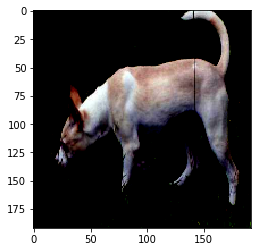

In [59]:
plt.imshow(load_and_preprocess_image(data_test_[522]))
plt.grid(False)
plt.show()